# PyTorch Neural Network

### Resource Link : https://www.learnpytorch.io/02_pytorch_classification/

### 1. Make classification data and get it ready

In [1]:
import torch
from torch import nn
import sklearn
from sklearn.datasets import make_circles
import pandas as pd
import matplotlib.pyplot as plt

In [69]:
n_samples = 1000
X, y = make_circles(n_samples,
                   noise = 0.03,
                   random_state = 5)
len(X), len(y)

(1000, 1000)

In [70]:
X[:5]

array([[ 0.75402483,  0.43755921],
       [ 0.81060642,  0.15734353],
       [-0.78916909,  0.63340529],
       [ 1.05156284,  0.10546473],
       [-0.92082444, -0.33689373]])

In [71]:
y[:5]

array([1, 1, 0, 0, 0], dtype=int64)

In [72]:
circles = pd.DataFrame({"X1": X[:, 0],
                        "X2": X[:, 1],
                        "label": y})
circles.head()

,X1,X2,label
0,0.754025,0.437559,1
1,0.810606,0.157344,1
2,-0.789169,0.633405,0
3,1.051563,0.105465,0
4,-0.920824,-0.336894,0


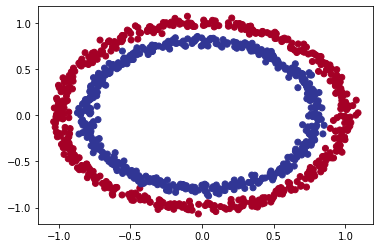

In [73]:
plt.scatter(x=X[:, 0],
            y=X[:, 1],
            c = y,
            cmap = plt.cm.RdYlBu)

In [74]:
X.shape, y.shape

((1000, 2), (1000,))

#### Turn data into tensors

In [75]:
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

In [76]:
X.dtype, y.dtype

(torch.float32, torch.float32)

#### Split data into train and test

In [77]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size = 0.2,
                                                    random_state = 5)

len(X_train), len(X_test)

(800, 200)

### 2. Build the model
#### Setup device agnostic code

In [78]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

#### Constrct the model with 2 linear layers and a forward method

In [79]:
class CircleModelV0(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features = 2, out_features = 5)
        self.layer_2 = nn.Linear(in_features = 5, out_features = 1)
        
    def forward(self, x):
        return self.layer_2(self.layer_1(x))

In [80]:
model_0 = CircleModelV0().to(device)
model_0

CircleModelV0(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

#### Using nn.Sequential()

In [81]:
model_0 = nn.Sequential(
                nn.Linear(in_features = 2, out_features = 5),
                nn.Linear(in_features = 5, out_features = 1)).to(device)

model_0

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

In [82]:
model_0.state_dict()

OrderedDict([('0.weight',
              tensor([[-0.3373, -0.6495],
                      [ 0.4031,  0.6720],
                      [-0.5793,  0.0386],
                      [ 0.2537, -0.3339],
                      [-0.1547, -0.4722]], device='cuda:0')),
             ('0.bias',
              tensor([-0.3343, -0.6446, -0.0164,  0.4193,  0.3439], device='cuda:0')),
             ('1.weight',
              tensor([[ 0.4201, -0.3928, -0.0550,  0.4354,  0.0732]], device='cuda:0')),
             ('1.bias', tensor([-0.1261], device='cuda:0'))])

#### Make untrained predictions

In [83]:
with torch.inference_mode():
    untrained_preds = model_0(X_test.to(device))
torch.round(untrained_preds[:5]), y_test[:5]

(tensor([[-0.],
         [-1.],
         [ 0.],
         [ 0.],
         [ 1.]], device='cuda:0'),
 tensor([1., 0., 0., 1., 0.]))

#### Loss function and optimizer

In [84]:
#Requires input to have gone thru the sigmoid activation fn prior to input to loss fn. Expects input in probs
loss_fn = nn.BCELoss()

#Sigmoid activation fn built in. More numerically stable. Expects input in logits.
loss_fn = nn.BCEWithLogitsLoss()

optimizer = torch.optim.SGD(params = model_0.parameters(),
                            lr = 0.1)

 #### Accuracy function

In [85]:
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = correct / len(y_pred) * 100
    return acc

### 3. Training the Model
1. Forward pass
2. Calculate loss
3. Optimizer zero grad
4. Loss backward
4. Optimizer step

Going from raw logits -> pred probs -> pred labels<br>
Convert logit to probs by passing through activation fn like sigmoid(binary) or softmax(multiclass)<br>
Convert pred probs to pred labels by rounding or taking the argmax

In [86]:
model_0.eval()
with torch.inference_mode():
    y_logits = model_0(X_test.to(device))[:5]
    
y_logits

tensor([[-0.2248],
        [-0.5310],
        [ 0.4322],
        [ 0.0909],
        [ 0.9102]], device='cuda:0')

In [20]:
y_pred_probs = torch.sigmoid(y_logits)
y_pred_probs

tensor([[0.5464],
        [0.5737],
        [0.5125],
        [0.5365],
        [0.4638]], device='cuda:0')

In [21]:
y_pred_labels = torch.round(y_pred_probs)
y_pred_labels

tensor([[1.],
        [1.],
        [1.],
        [1.],
        [0.]], device='cuda:0')

In [22]:
torch.eq(y_pred_labels.squeeze().to(device), y_test[:5].to(device))

tensor([ True, False, False,  True,  True], device='cuda:0')

#### Training and Testing Loop

In [23]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

epochs = 1001

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
    model_0.train()
    
    y_logits = model_0(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))
    
    loss = loss_fn(y_logits, y_train)
    acc = accuracy_fn(y_true = y_train, y_pred = y_pred)
    
    optimizer.zero_grad()
    
    loss.backward()
    
    optimizer.step()
    
    model_0.eval()
    with torch.inference_mode():
        test_logits = model_0(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))
        
        test_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy_fn(y_true = y_test, y_pred = test_pred)
        
    if epoch%100 == 0:
        print(f"Epoch : {epoch}")
        print(f"Train Loss : {loss}")
        print(f"Train Accuracy : {acc}")
        print(f"Test Loss : {test_loss}")
        print(f"Test Accuracy : {test_acc}")

Epoch : 0
Train Loss : 0.6983569264411926
Train Accuracy : 50.24999999999999
Test Loss : 0.6891060471534729
Test Accuracy : 55.50000000000001
Epoch : 100
Train Loss : 0.693374752998352
Train Accuracy : 48.75
Test Loss : 0.6931107044219971
Test Accuracy : 48.5
Epoch : 200
Train Loss : 0.6929841637611389
Train Accuracy : 46.5
Test Loss : 0.694629430770874
Test Accuracy : 44.0
Epoch : 300
Train Loss : 0.6929298043251038
Train Accuracy : 48.75
Test Loss : 0.6951588988304138
Test Accuracy : 42.5
Epoch : 400
Train Loss : 0.6929197311401367
Train Accuracy : 48.75
Test Loss : 0.6953343749046326
Test Accuracy : 42.5
Epoch : 500
Train Loss : 0.6929174661636353
Train Accuracy : 48.75
Test Loss : 0.6953935623168945
Test Accuracy : 44.0
Epoch : 600
Train Loss : 0.6929168701171875
Train Accuracy : 48.625
Test Loss : 0.6954147219657898
Test Accuracy : 44.0
Epoch : 700
Train Loss : 0.692916750907898
Train Accuracy : 48.875
Test Loss : 0.6954226493835449
Test Accuracy : 44.0
Epoch : 800
Train Loss : 0.

### 4. Evaluate the model

In [24]:
import requests
from pathlib import Path

if Path("helper_functions.py").is_file():
    print("skip download")
else:
    request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
    with open("helper_functions.py", "wb") as f:
        f.write(request.content)
        
from helper_functions import plot_predictions, plot_decision_boundary

skip download


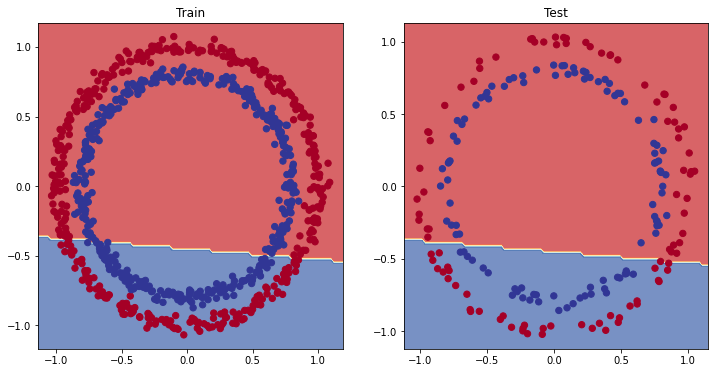

In [25]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_0, X_test, y_test)

### 5. Improving the model
1. Add more layers - more chances to learn the patterns in the data
2. Add more hidden units
3. Fit for longer
4. Change the activation functions
5. Change the learning rate
6. Change the loss function

These are all hyperparameters

In [26]:
class CircleModelV1(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features = 2, out_features = 10)
        self.layer_2 = nn.Linear(in_features = 10, out_features = 10)
        self.layer_3 = nn.Linear(in_features = 10, out_features = 1)
        
    def forward(self, x):
        return self.layer_3(self.layer_2(self.layer_1(x)))

In [27]:
model_1 = CircleModelV1().to(device)
model_1

CircleModelV1(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
)

In [28]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(params = model_1.parameters(), lr = 0.1)

In [29]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

epochs = 1001

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
    model_1.train()
    
    y_logits = model_1(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))
    
    loss = loss_fn(y_logits, y_train)
    acc = accuracy_fn(y_true = y_train, y_pred = y_pred)
    
    optimizer.zero_grad()
    
    loss.backward()
    
    optimizer.step()
    
    model_1.eval()
    with torch.inference_mode():
        test_logits = model_1(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))
        
        test_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy_fn(y_true = y_test, y_pred = test_pred)
        
    if epoch%100 == 0:
        print(f"Epoch : {epoch}")
        print(f"Train Loss : {loss}")
        print(f"Train Accuracy : {acc}")
        print(f"Test Loss : {test_loss}")
        print(f"Test Accuracy : {test_acc}")

Epoch : 0
Train Loss : 0.693806529045105
Train Accuracy : 51.37500000000001
Test Loss : 0.6932815313339233
Test Accuracy : 49.5
Epoch : 100
Train Loss : 0.692947268486023
Train Accuracy : 48.125
Test Loss : 0.6950394511222839
Test Accuracy : 43.0
Epoch : 200
Train Loss : 0.6929185390472412
Train Accuracy : 48.5
Test Loss : 0.6953049302101135
Test Accuracy : 45.5
Epoch : 300
Train Loss : 0.6929168701171875
Train Accuracy : 49.125
Test Loss : 0.695389986038208
Test Accuracy : 45.0
Epoch : 400
Train Loss : 0.6929166913032532
Train Accuracy : 49.0
Test Loss : 0.6954164505004883
Test Accuracy : 44.5
Epoch : 500
Train Loss : 0.6929166913032532
Train Accuracy : 49.0
Test Loss : 0.6954247355461121
Test Accuracy : 44.0
Epoch : 600
Train Loss : 0.6929166913032532
Train Accuracy : 49.125
Test Loss : 0.6954273581504822
Test Accuracy : 44.0
Epoch : 700
Train Loss : 0.6929166913032532
Train Accuracy : 49.125
Test Loss : 0.6954283118247986
Test Accuracy : 44.0
Epoch : 800
Train Loss : 0.6929166913032

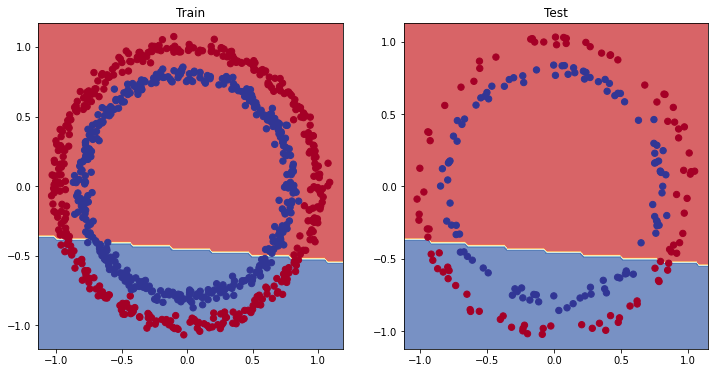

In [30]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_1, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_1, X_test, y_test)

### Making a non linear model

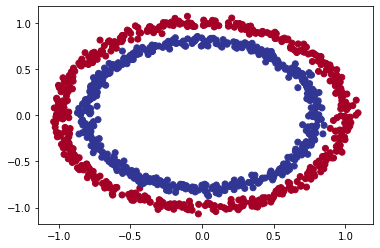

In [31]:
plt.scatter(x=X[:, 0],
            y=X[:, 1],
            c = y,
            cmap = plt.cm.RdYlBu)

In [32]:
X.dtype, y.dtype

(torch.float32, torch.float32)

In [33]:
len(X_train), len(X_test)

(800, 200)

In [34]:
class CircleModelNonLinear(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features = 2, out_features = 10)
        self.layer_2 = nn.Linear(in_features = 10, out_features = 10)
        self.layer_3 = nn.Linear(in_features = 10, out_features = 1)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))

In [35]:
model_nl = CircleModelNonLinear().to(device)
model_nl

CircleModelNonLinear(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)

In [36]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(params = model_nl.parameters(), lr = 0.1)

In [37]:
torch.manual_seed(5)
torch.cuda.manual_seed(5)

epochs = 1001

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
    model_nl.train()
    
    y_logits = model_nl(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))
    
    loss = loss_fn(y_logits, y_train)
    acc = accuracy_fn(y_true = y_train, y_pred = y_pred)
    
    optimizer.zero_grad()
    
    loss.backward()
    
    optimizer.step()
    
    model_nl.eval()
    with torch.inference_mode():
        test_logits = model_nl(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))
        
        test_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy_fn(y_true = y_test, y_pred = test_pred)
        
    if epoch%100 == 0:
        print(f"Epoch : {epoch}")
        print(f"Train Loss : {loss}")
        print(f"Train Accuracy : {acc}")
        print(f"Test Loss : {test_loss}")
        print(f"Test Accuracy : {test_acc}")

Epoch : 0
Train Loss : 0.69317626953125
Train Accuracy : 49.375
Test Loss : 0.6921839714050293
Test Accuracy : 52.5
Epoch : 100
Train Loss : 0.6908324956893921
Train Accuracy : 51.625
Test Loss : 0.6919683814048767
Test Accuracy : 49.5
Epoch : 200
Train Loss : 0.6890140175819397
Train Accuracy : 52.5
Test Loss : 0.6910648345947266
Test Accuracy : 51.0
Epoch : 300
Train Loss : 0.6865659952163696
Train Accuracy : 53.5
Test Loss : 0.6896570324897766
Test Accuracy : 50.5
Epoch : 400
Train Loss : 0.6827996969223022
Train Accuracy : 53.87499999999999
Test Loss : 0.6870033740997314
Test Accuracy : 49.5
Epoch : 500
Train Loss : 0.6773144602775574
Train Accuracy : 54.25
Test Loss : 0.6828683614730835
Test Accuracy : 49.5
Epoch : 600
Train Loss : 0.6686848402023315
Train Accuracy : 54.625
Test Loss : 0.6760765910148621
Test Accuracy : 49.5
Epoch : 700
Train Loss : 0.6565734148025513
Train Accuracy : 58.75
Test Loss : 0.6673665642738342
Test Accuracy : 51.5
Epoch : 800
Train Loss : 0.638296902179

### Evaluating non linear model

In [38]:
model_nl.eval()
with torch.inference_mode():
    y_preds = torch.round(torch.sigmoid(model_nl(X_test.to(device)))).squeeze()
y_preds[:10], y_test[:10]

(tensor([0., 0., 0., 1., 1., 0., 1., 0., 1., 0.], device='cuda:0'),
 tensor([1., 0., 0., 1., 0., 0., 1., 0., 1., 1.], device='cuda:0'))

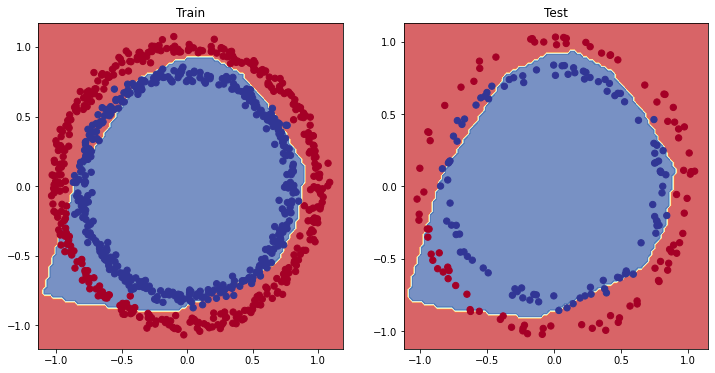

In [39]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_nl, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_nl, X_test, y_test)

## Multi-class Classification
### Creating data

In [40]:
from sklearn.datasets import make_blobs

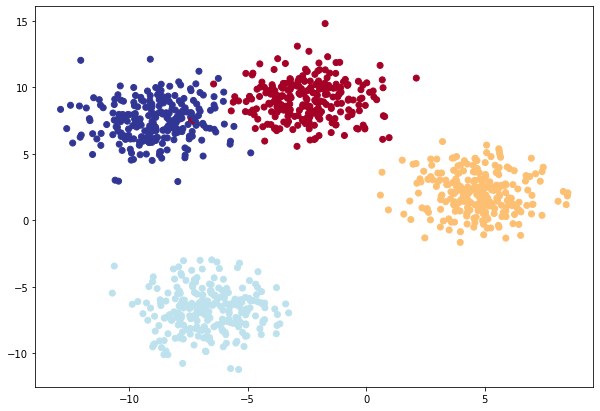

In [54]:
NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42

X_blob, y_blob = make_blobs(n_samples = 1000, n_features = NUM_FEATURES, centers = NUM_CLASSES,
                            cluster_std = 1.5, # give the clusters a shake up
                            random_state = RANDOM_SEED)

X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor)

X_train, X_test, y_train, y_test = train_test_split(X_blob, y_blob, test_size = 0.2, random_state = RANDOM_SEED)

plt.figure(figsize = (10, 7))
plt.scatter(X_blob[:, 0], X_blob[:, 1], c = y_blob, cmap = plt.cm.RdYlBu)

### Creating model
Logits -> Pred Probs (softmax) -> Pred labels (argmax)

In [55]:
class MulticlassModel(nn.Module):
    def __init__(self, input_features, output_features, hidden_units=8):
        super().__init__()
        self.linear_layer_stack = nn.Sequential(nn.Linear(in_features = input_features, out_features = hidden_units),
                                                nn.ReLU(),
                                                nn.Linear(in_features = hidden_units, out_features = hidden_units),
                                                nn.ReLU(),
                                                nn.Linear(in_features = hidden_units, out_features = output_features))
        
    def forward(self, x):
        return self.linear_layer_stack(x)

In [56]:
model_blob = MulticlassModel(input_features = 2, output_features = 4).to(device)
model_blob

MulticlassModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=4, bias=True)
  )
)

In [57]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params = model_blob.parameters(), lr = 0.1)

In [58]:
X_test = X_test.to(device)

model_blob.eval()
with torch.inference_mode():
    y_logits = model_blob(X_test)
    
y_pred_probs = torch.softmax(y_logits, dim = 1) #across the first dimension

y_pred_probs

tensor([[1.3019e-01, 2.1650e-01, 3.2293e-01, 3.3038e-01],
        [7.2629e-03, 8.9883e-03, 2.5704e-01, 7.2671e-01],
        [2.7420e-01, 2.6307e-01, 2.1784e-01, 2.4489e-01],
        [2.0524e-01, 2.4968e-01, 3.1512e-01, 2.2997e-01],
        [1.1540e-02, 2.8821e-02, 3.7543e-01, 5.8421e-01],
        [3.3559e-03, 3.8872e-03, 2.2467e-01, 7.6808e-01],
        [2.6701e-01, 3.0606e-01, 2.0046e-01, 2.2646e-01],
        [1.1588e-02, 2.5822e-02, 3.3612e-01, 6.2647e-01],
        [1.8658e-01, 1.4638e-01, 2.6277e-01, 4.0428e-01],
        [1.2371e-02, 2.8542e-02, 3.5189e-01, 6.0720e-01],
        [1.2214e-02, 2.5093e-02, 3.1866e-01, 6.4404e-01],
        [1.2336e-01, 2.1023e-01, 3.3682e-01, 3.2959e-01],
        [1.0114e-02, 2.4805e-02, 3.6080e-01, 6.0429e-01],
        [7.2256e-03, 1.7256e-02, 3.3036e-01, 6.4516e-01],
        [5.6935e-03, 1.4237e-02, 3.3070e-01, 6.4937e-01],
        [1.0153e-02, 1.3428e-02, 2.7445e-01, 7.0196e-01],
        [6.6053e-03, 8.0326e-03, 2.5234e-01, 7.3302e-01],
        [1.678

In [59]:
y_preds = torch.argmax(y_pred_probs, dim = 1)
y_preds

tensor([3, 3, 0, 2, 3, 3, 1, 3, 3, 3, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1,
        1, 3, 3, 3, 3, 3, 3, 2, 2, 3, 2, 3, 2, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 2, 3, 3, 2, 3, 3, 2, 2, 3, 0, 3, 3, 3, 3, 0, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3, 3,
        2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3, 3, 2, 2, 3, 0, 0, 3, 3, 3, 2, 3,
        3, 3, 3, 2, 1, 3, 3, 3, 0, 3, 3, 1, 3, 1, 3, 3, 3, 3, 2, 2, 2, 3, 1, 3,
        3, 3, 3, 3, 3, 3, 1, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 0, 3,
        1, 1, 1, 3, 3, 2, 2, 2, 2, 2, 3, 2, 3, 1, 1, 3, 1, 3, 3, 3, 1, 3, 3, 3,
        2, 3, 3, 3, 3, 2, 3, 2], device='cuda:0')

### Build the training and testing loop

In [60]:
torch.manual_seed(5)
torch.cuda.manual_seed(5)

epochs = 501

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
    model_blob.train()
    
    y_logits = model_blob(X_train)
    y_pred = torch.softmax(y_logits, dim=1).argmax(dim = 1)
    
    loss = loss_fn(y_logits, y_train)
    acc = accuracy_fn(y_true = y_train, y_pred = y_pred)
    
    optimizer.zero_grad()
    
    loss.backward()
    
    optimizer.step()
    
    model_blob.eval()
    with torch.inference_mode():
        test_logits = model_blob(X_test)
        test_pred = torch.softmax(test_logits, dim=1).argmax(dim = 1)
        
        test_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy_fn(y_true = y_test, y_pred = test_pred)
        
    if epoch%100 == 0:
        print(f"Epoch : {epoch}")
        print(f"Train Loss : {loss}")
        print(f"Train Accuracy : {acc}")
        print(f"Test Loss : {test_loss}")
        print(f"Test Accuracy : {test_acc}")

Epoch : 0
Train Loss : 1.9607000350952148
Train Accuracy : 24.625
Test Loss : 1.2028071880340576
Test Accuracy : 31.0
Epoch : 100
Train Loss : 0.03610249608755112
Train Accuracy : 99.25
Test Loss : 0.025602120906114578
Test Accuracy : 99.5
Epoch : 200
Train Loss : 0.02709174156188965
Train Accuracy : 99.375
Test Loss : 0.016333680599927902
Test Accuracy : 99.5
Epoch : 300
Train Loss : 0.025136297568678856
Train Accuracy : 99.375
Test Loss : 0.013936224393546581
Test Accuracy : 99.5
Epoch : 400
Train Loss : 0.022771449759602547
Train Accuracy : 99.375
Test Loss : 0.012831849046051502
Test Accuracy : 99.5
Epoch : 500
Train Loss : 0.021896949037909508
Train Accuracy : 99.375
Test Loss : 0.011867741122841835
Test Accuracy : 99.5


In [61]:
model_blob.eval()
with torch.inference_mode():
    y_preds = torch.softmax(model_blob(X_test), dim=1).argmax(dim = 1)
y_preds[:10], y_test[:10]

(tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0], device='cuda:0'),
 tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0], device='cuda:0'))

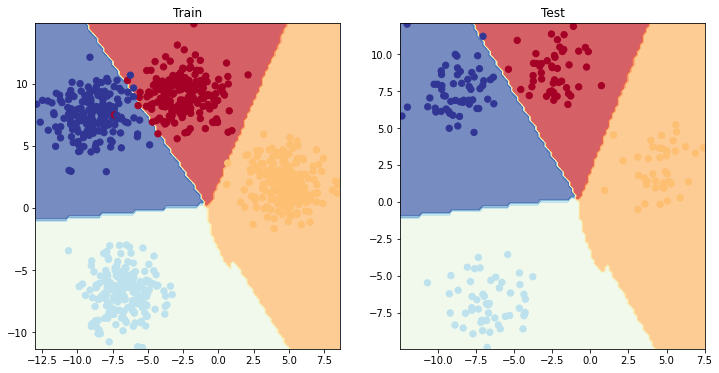

In [62]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_blob, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_blob, X_test, y_test)

### Classification Metrics
1. Accuracy
2. Precision
3. Recall
4. F1-score
5. Confusion Matrix
6. Classification Report

In [68]:
from torchmetrics import Accuracy

t_acc = Accuracy(task='multiclass', num_classes = 4).to(device)
t_acc(y_preds, y_test)

tensor(0.9950, device='cuda:0')